<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Task_2_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 2: Smae procedure just now we use pre-trained CNN instead of autoencoder.

## Load Pretrained CNN and CIFAR-10

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Load CIFAR-10 test set
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor()
])

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Set to evaluation mode


100%|██████████| 170M/170M [00:01<00:00, 101MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Extract Features from CNN

In [2]:
from torch import nn

# Remove the final classification layer
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])  # Output: (batch_size, 512, 1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Collect features and labels
features = []
labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)
        feats = feats.view(feats.size(0), -1)  # Flatten to (batch_size, 512)
        features.append(feats.cpu())
        labels.append(lbls)

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()


## Dimensionality Reduction (PCA and t-SNE)

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ----- PCA -----
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# ----- t-SNE -----
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features)


## Visualize PCA and t-SNE Features

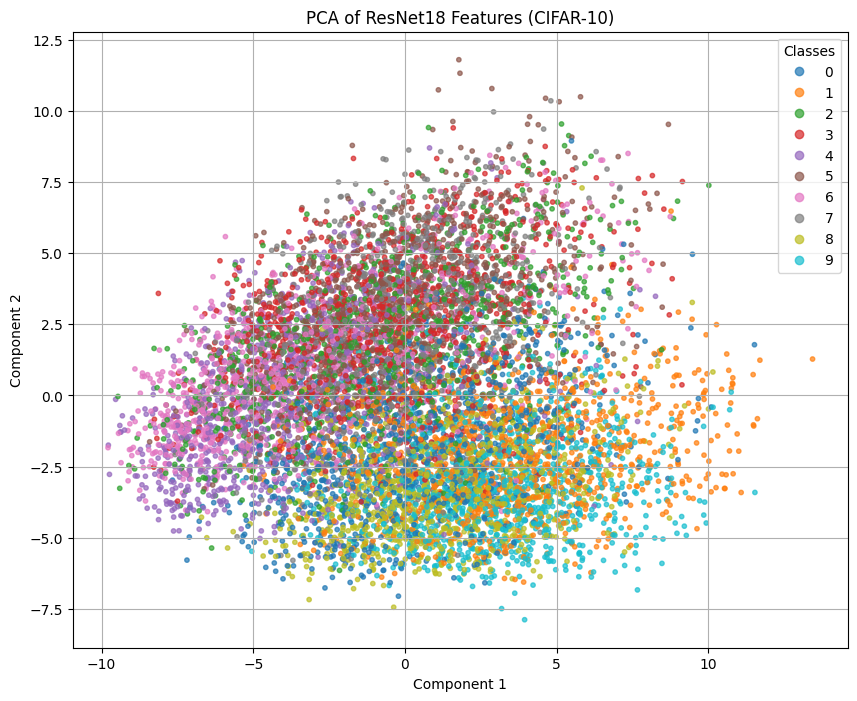

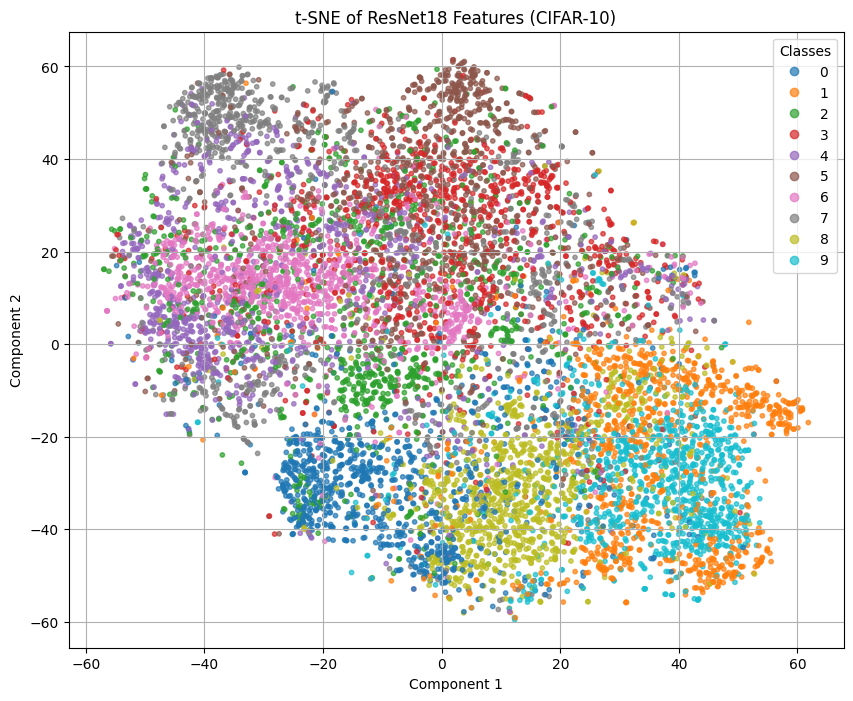

In [4]:
def plot_2d(features, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Plot PCA-reduced features
plot_2d(features_pca, labels, "PCA of ResNet18 Features (CIFAR-10)")

# Plot t-SNE-reduced features
plot_2d(features_tsne, labels, "t-SNE of ResNet18 Features (CIFAR-10)")
